In [9]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
from dotenv import load_dotenv

import numpy as np
from matplotlib import pyplot as plt

# Import Utility Functions
from collab_env.data.file_utils import expand_path, get_project_root
from collab_env.data.gcs_utils import GCSClient

from collab_env.alignment import align
from collab_env.utils import visualization as viz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setup API keys

In [4]:
# Load environment variables from .env file
load_dotenv()
data_key = os.environ.get("COLLAB_DATA_KEY")

print(f"Data key: {data_key}")

Data key: /workspace/api-keys/collab-data-463313-c340ad86b28e.json


### Download an RGB video

In [5]:
CURRENT_PROJECT = "COLLAB_DATA"
PROJECT_KEY = Path(os.environ.get(f"{CURRENT_PROJECT}_KEY"))
PROJECT_ID = "-".join(PROJECT_KEY.stem.split("-")[:-1])

# Connect to GCS
gcs_client = GCSClient(
    project_id=PROJECT_ID,
    credentials_path=expand_path(PROJECT_KEY.as_posix(), get_project_root()),
)

2025-08-15 18:26:02.774 | INFO     | collab_env.data.gcs_utils:__init__:34 - Using credentials from /workspace/api-keys/collab-data-463313-c340ad86b28e.json
2025-08-15 18:26:02.781 | INFO     | collab_env.data.gcs_utils:__init__:40 - Using project collab-data-463313


Find all buckets and grab the videos for the desired session

In [6]:
CURRENT_SESSION = "2024_02_06"
CURRENT_BUCKET = gcs_client.list_buckets()[1]
DTYPE = 'processed'

assert DTYPE in CURRENT_BUCKET, "Current bucket is not the processed bucket"

# Grab the aligned frames for the current session
current_session_dir = gcs_client.glob(f"{CURRENT_BUCKET}/{CURRENT_SESSION}*")[0]

# Set the current output directory
local_out_dir = get_project_root() / "data" / current_session_dir

Download aligned files and splat environment

In [5]:
# Download aligned frames and environment directories
for dir_name in ["aligned_frames", "environment"]:
    gcs_path = f"{current_session_dir}/{dir_name}"
    local_path = local_out_dir / dir_name

    # if not local_path.exists():
    gcs_client.download_folder(gcs_path, local_path)

2025-08-14 20:47:32.316 | INFO     | collab_env.data.gcs_utils:download_folder:217 - Downloading folder fieldwork_processed/2024_02_06-session_0001/aligned_frames to /workspace/collab-environment/data/fieldwork_processed/2024_02_06-session_0001/aligned_frames.
2025-08-14 20:47:32.468 | INFO     | collab_env.data.gcs_utils:download_folder:253 - Finished downloading folder fieldwork_processed/2024_02_06-session_0001/aligned_frames/ to /workspace/collab-environment/data/fieldwork_processed/2024_02_06-session_0001/aligned_frames.
2025-08-14 20:47:32.470 | INFO     | collab_env.data.gcs_utils:download_folder:217 - Downloading folder fieldwork_processed/2024_02_06-session_0001/environment to /workspace/collab-environment/data/fieldwork_processed/2024_02_06-session_0001/environment.
2025-08-14 20:47:34.787 | INFO     | collab_env.data.gcs_utils:download_folder:253 - Finished downloading folder fieldwork_processed/2024_02_06-session_0001/environment/ to /workspace/collab-environment/data/field

## Aligning cameras

To align the cameras, we require the following folders:
1. **aligned_dir:** spatiotemporally aligned RGB video to the thermal tracking

2. **environment_dir:** processed hloc + COLMAP information from collab-splats

We load a video and sample frames (only really need one) which are then aligned to the camera poses used to fit the splats. Sampled frames are called *"queries"* and are localized within the splat scene.

In [106]:
splat_video = "C0043"
camera_id = "rgb_1"

# Directory containing the RGB-Thermal aligned video (maps to tracks)
aligned_dir = local_out_dir / "aligned_frames" / camera_id
aligned_video_fn = aligned_dir / f"adjusted_{camera_id}.mp4"

# Environment directory information -- contains the 
environment_dir = local_out_dir / "environment" # Path to environment directory
preproc_dir = environment_dir / splat_video / "preproc" # Path to colmap preproc directory
mesh_dir = environment_dir / splat_video / "rade-features" / "mesh"

# Outputs are written to aligned_splat dir keeping track of the query frames
output_dir = local_out_dir / "aligned_splat" / camera_id
query_dir = output_dir / "sampled-frames"

Load the RGB-Thermal aligned video and write frames to a directory

In [23]:
# Set the random seed to ensure same frame is sampled each time
np.random.seed(42)

frame_fns = align.extract_video_frames(
    video_path=aligned_video_fn, 
    output_dir=query_dir, 
    n_frames=1, 
    method='random'
)

Plot the frame to make sure things look okay

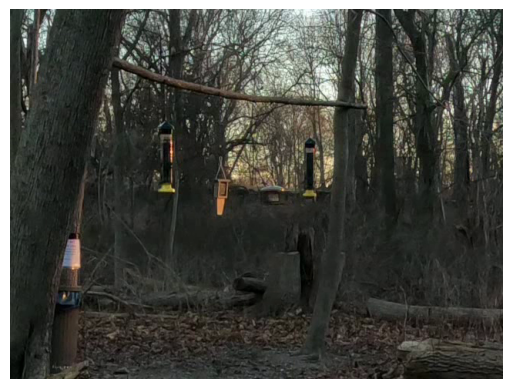

In [24]:
image = plt.imread(frame_fns[0])
plt.imshow(image)
plt.axis('off')
plt.show()

### Localize a camera position

Internally, we use hloc to extract features from the query images and match these features to the images used to build the splat

In [97]:
# Align the new camera to the COLMAP fit
localized_poses, logs, viz_info = align.align_to_colmap(
    preproc_dir=preproc_dir,
    query_dir=query_dir,
    output_dir=output_dir,
    return_logs=True, # Returns logs + viz info for visualization otherwise would only return poses
)

/workspace/collab-environment/collab_env/alignment/align.py:302: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  'width': int(width),


Creating output directory...


[2025/08/15 19:10:39 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}


Extracting features from queries and matching...
Loaded SuperPoint model


100%|██████████| 1/1 [00:00<00:00,  8.34it/s]
[2025/08/15 19:10:39 hloc INFO] Finished exporting features.
[2025/08/15 19:10:39 hloc INFO] Found 597 pairs.
[2025/08/15 19:10:39 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 597/597 [00:24<00:00, 24.46it/s]
[2025/08/15 19:11:05 hloc INFO] Finished exporting matches.
Localizing query images...: 100%|██████████| 1/1 [00:04<00:00,  4.27s/it]


Running this function returns the camera parameters aligned to the COLMAP cameras. We can visualize the quality of this alignment using the hloc toolbox

**(Left)** Query image

**(Right)** Best match original pose

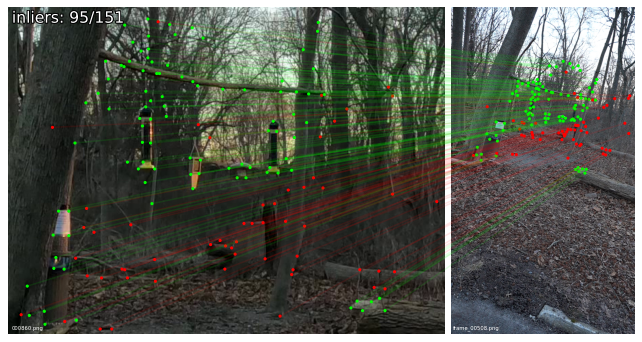

In [99]:
from hloc.visualization import visualize_loc_from_log

# Grab the log from the first query image
query_logs = logs[0]

# Visualize the localization results
visualize_loc_from_log(
    image_dir = query_logs['query'].parent, 
    query_name = query_logs['query'].name, 
    loc = query_logs['loc'],
    top_k_db=1, # Only show the target image and the best match
    **viz_info, # Contains the directory of original images + the colmap model
)

Align the localization to the mesh

In [108]:
# Grab the localized pose
pose = localized_poses[0]

# Extract camera information from that pose and format
camera_params = align.extract_camera_params(pose)

# Align the camera to the mesh and save
aligned_camera_params = align.align_to_mesh(
    camera_params=camera_params,
    mesh_dir=mesh_dir,
    out_fn=output_dir / f"{camera_id}_mesh-aligned.pkl",
)

#### Optional visualizations and metrics

Visualize camera perspective of the mesh

(-0.5, 639.5, 479.5, -0.5)

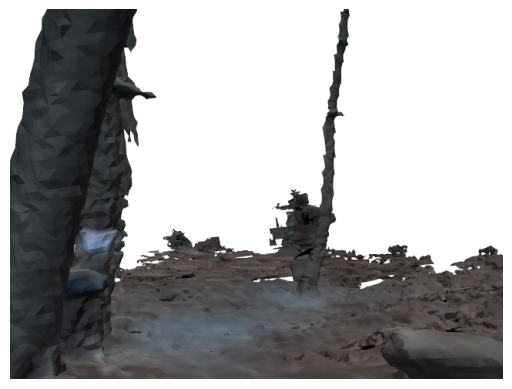

In [132]:
from copy import deepcopy

# Get out mesh filename
mesh_fn = mesh_dir / "mesh.ply"

# Copy the parameters and format for pyvista
pv_camera = deepcopy(aligned_camera_params)
pv_viz_kwargs = viz.format_pyvista_camera_params(pv_camera)

# Visualize the camera view
plotter = viz.visualize_splat(
    mesh_fn.as_posix(), 
    mesh_kwargs=viz.MESH_KWARGS,
    viz_kwargs=pv_viz_kwargs,
)

# Render the camera view as an image
view_image = plotter.screenshot(return_img=True)
plt.imshow(view_image)
plt.axis('off')

Compute the similarity between the viewed image and ground truth

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/conda/envs/collab-env/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


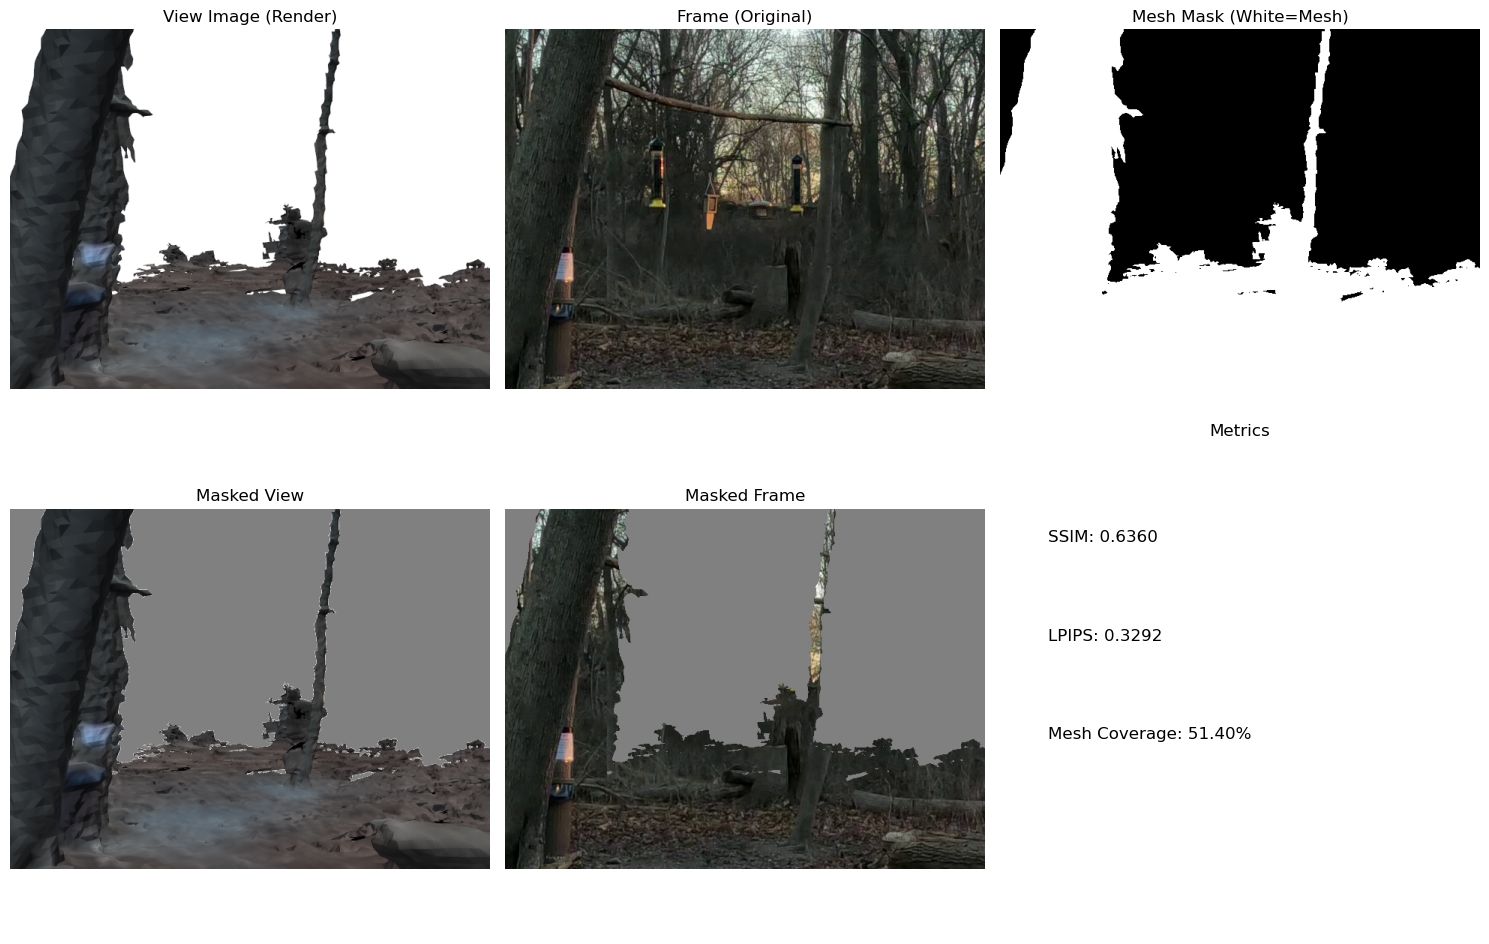

In [136]:
frame = plt.imread(frame_fns[0])

result = align.compute_image_similarity(
    view_image=view_image, 
    frame=frame, 
)

comparison_plot = align.visualize_comparison(view_image, frame, result)

Show camera position on mesh

(-0.5, 799.5, 799.5, -0.5)

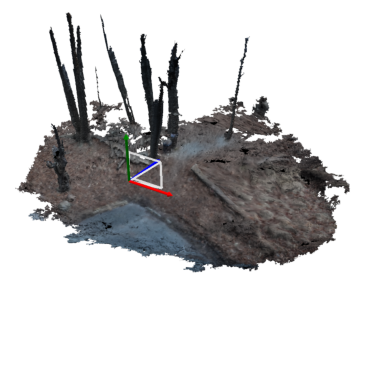

In [137]:
# Create custom camera kwargs to apply to the visualization
camera_kwargs = viz.CAMERA_KWARGS.copy()

# These format the camera frustum visualization
camera_kwargs['line_width'] = 5
camera_kwargs['scale'] = 0.025
camera_kwargs['opacity'] = 0.9
camera_kwargs['color'] = [0.9, 0.9, 0.9]
camera_kwargs['show_axes'] = True

# Grab our localized camera's pose
poses = [pv_camera['c2w']]

# Visualize the splat
plotter = viz.visualize_splat(
    mesh_fn.as_posix(), 
    poses,
    mesh_kwargs=viz.MESH_KWARGS,
    viz_kwargs=viz.VIZ_KWARGS,
    camera_kwargs=camera_kwargs,
)

# plotter.show(window_size=(800, 800))
mesh_image = plotter.screenshot(window_size=(800, 800))

plt.imshow(mesh_image)
plt.axis('off')

### Compute view similarity

In [ ]:
result = align.compute_image_similarity(image, frame, mask_method='edge', background_threshold=225)

comparison_plot = align.visualize_comparison(image, frame, result)